<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

# Landlab Landslide Component Demonstration with a Synthetic Grid

**Two Hydrologic Forcing Options (Depth to Groundwater and Recharge) are compared using four statistical distributions (Uniform, Lognormal, Spatial-Lognormal, Spatial Data-Driven), and the default range of parameters**


<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>
<hr>

## 0.  Software Setup and Preparation

To run this notebook, we must import several libraries.
The hs_utils library provides functions for interacting with HydroShare, including resource querying, dowloading, and creation.  Additional libraries support the functions of Landlab. 

### Import Landlab and other Python utilities

In [1]:
import numpy as np

from landlab import RasterModelGrid
from landlab.components.landslides import LandslideProbability
import landlab.plot.landslides.plot_landslides as pl
import tests.components.landslides.test_landslide_probability as test

#temporary code for Ronda Binder/JH demo test in Binder before Pull Request
#import LandslideProbability
#import plot_landslides as pl
#import test_landslide_probability as test

### Landslide Component Definitions
#### key variables and functions in `test_landslide_probability.py`


`grid` is the Landlab raster model grid initialization

`ls_grid` is a `grid`  with landslide parameters added to nodes
The input fields (see input_var_names) on the node are initialized in this step.

`ls_grid` is input to `LandslideProbability()` to add model parameters to define the size of the Monte Carlo method, statistical distribution (four options), and hydrologic forcings (two options: recharge OR depth to water table) for the landslide model. A distribution of hydrologic forcing is used to calculate the probability of lansdlides in the Factor of Safety equation; the mean hydrologic forcing  per node has been added as a model output (in addition to relative wetness, probability of saturation, and probability of failure). 

`ls_prob` is the output of `LandslideProbability()` and considered a model instance (or model initialization).

`ls_prob` is the input to `calculate_landslide_probability()`. Model results are saved in the same input dictionary by adding output fields.

`ls_prob` is both the input and output of  `calculate_landslide_probability()` and should be saved, or recalculated with a clean `ls_grid` to ensure variables are saved as expected (not overwritten) for each change of parameters and model calculation.

The output fields (see output_var_names) on the node are initialized to zero, and contain the model results. 

## 1. Create a synthetic grid with landslide unit_default data fields

**1.1 Use the unit test to build a synthetic grid investigate features of the grid.** 

The total number of nodes is limited to 20, which is fast for computers and easy for humans.

In [2]:
shape = (5, 4)
spacing = (10e0, 10e0)
coordinates = (0.0, 0.0)
grid = RasterModelGrid(shape,spacing,coordinates)

print('The synthetic grid `grid` is a Landlab RasterModelGrid: {value}. '.format(value=grid))
grid

The synthetic grid `grid` is a Landlab RasterModelGrid: <xarray.Dataset>
Dimensions:         (Two: 2, cell: 6, face: 17, link: 31, max_patch_links: 4, node: 20, patch: 12)
Coordinates:
  * node            (node) int32 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19
Dimensions without coordinates: Two, cell, face, link, max_patch_links, patch
Data variables:
    mesh            <U1 'a'
    y_of_node       (node) float64 0.0 0.0 0.0 0.0 10.0 ... 40.0 40.0 40.0 40.0
    x_of_node       (node) float64 0.0 10.0 20.0 30.0 0.0 ... 0.0 10.0 20.0 30.0
    nodes_at_link   (link, Two) int32 0 1 1 2 2 3 0 4 ... 19 16 17 17 18 18 19
    links_at_patch  (patch, max_patch_links) int32 4 7 3 0 5 ... 22 27 30 26 23
    node_at_cell    (cell) int32 5 6 9 10 13 14
    nodes_at_face   (face, Two) int32 1 5 2 6 4 5 5 6 ... 14 14 15 13 17 14 18. 


RasterModelGrid((5, 4), xy_spacing=(10.0, 10.0), xy_of_lower_left=(0.0, 0.0))

In [3]:
 sorted(LandslideProbability.input_var_names)

['soil__density',
 'soil__internal_friction_angle',
 'soil__maximum_total_cohesion',
 'soil__minimum_total_cohesion',
 'soil__mode_total_cohesion',
 'soil__saturated_hydraulic_conductivity',
 'soil__thickness',
 'soil__transmissivity',
 'topographic__slope',
 'topographic__specific_contributing_area']

## Write a function to build a landslide component unit grid

In [4]:
def build_landslide_unitgrid(shape,spacing,coordinates,forcing):
    # 1. Build a Landlab grid
    grid = RasterModelGrid(shape,spacing,coordinates)
    gridnum = grid.number_of_nodes
    # 2. Get range of default landslide parameters
    unit_default_value = test.calc_unit_default_value()
    # 3. Distribute and Add the parameters to each node on a Landlab grid
    ls_grid = test.landslide_pars_ongrid(grid, gridnum, unit_default_value)
    # 4. Calculate default depth and recharge forcing range as a function of relative wetness,
    # given the default unit grid inputs (Recharge = f(rw, T, a, slope); Depth = f(rw, hs))
    relative_wetness = 0.75
    Default_R, Default_D=test.scenario_unit_explorer(relative_wetness,ls_grid)
    # 5. Distribute and Add the parameters to a Landlab grid that will be linked to the landslide model instance
    if forcing == 'depth':
        ls_prob = LandslideProbability(
        ls_grid,
        number_of_iterations=25,
        groundwater__depth_distribution="uniform",
        groundwater__depth_min_value=Default_D[0],
        groundwater__depth_max_value=Default_D[1]
        )
    else: 
        ls_prob = LandslideProbability(
        ls_grid,
        number_of_iterations=25,
        groundwater__recharge_distribution="uniform",
        groundwater__depth_min_value=Default_R[0],
        groundwater__depth_max_value=Default_R[1]
        )
    ## sometimes a grid format is easier to work with, other times, it's easier to maintain the linked 
    ## model instance with a new grid for each model test
    return ls_prob, ls_grid

In [5]:
test_unit_defaultpars=test.get_default_nodevalues()
test_unit_defaultpars

{'topographic__slope': (0.1, 0.8),
 'topographic__specific_contributing_area': (10, 100),
 'soil__transmissivity': (0.1, 10),
 'soil__mode_total_cohesion': (30, 900),
 'soil__minimum_total_cohesion': (21, 891),
 'soil__maximum_total_cohesion': (39, 909),
 'soil__internal_friction_angle': (26, 37),
 'soil__thickness': (0.1, 1),
 'soil__density': (1999, 2001),
 'soil__saturated_hydraulic_conductivity': (0.1, 100.0),
 'landslide__probability_of_failure': (0, 1),
 'soil__mean_relative_wetness': (0, 1),
 'soil__mean_watertable_depth': (0, 1000),
 'soil__mean_recharge': (0, 1000),
 'soil__probability_of_saturation': (0, 1)}

### 1.13 Make Landslide Unit Grid Maps

The plot function `plot_landslide_4variables()` uses the Landlab plotting function `imshow_grid()` and creates subplots for any 4 variables on a Landlab grid.

Let's see what one of these fields (slope) looks like on the grid of 10 x 10 m grid cells. 

 ### 2.3. Recharge and Depth Options - 'uniform' distribution 

In this option, we'll apply a uniform distribution of recharge and depth based on minimum and maximum recharge and depth values.  We will then instantiate the LandslideProbability component with these parameters, as well as the grid and number of iterations we specified above.  Instantiate creates an instance of a class.  (For example, the _iPhone_ is a class and _each phone_ is an instance.)

No outputs are generated by these commands as they are setting up the recharge and depth and instantiating the component.


In [6]:
LS_prob1_r,grid_r1 = build_landslide_unitgrid(shape,spacing,coordinates,'recharge')
LS_prob1_d,grid_d1 = build_landslide_unitgrid(shape,spacing,coordinates,'depth')

print("Recharge Hydrologic Forcing")
LS_prob1_r.calculate_landslide_probability()
test.print_list_nodevalues(LS_prob1_r,["landslide__probability_of_failure"])
test.print_failure_nodevalues(LS_prob1_r)
print("Depth Hydrologic Forcing")
LS_prob1_d.calculate_landslide_probability()
test.print_list_nodevalues(LS_prob1_d,["landslide__probability_of_failure"])
test.print_failure_nodevalues(LS_prob1_d)

print("Unit test core node 6 = {value}".format(value=LS_prob1_d.grid.at_node["landslide__probability_of_failure"][5]))
print("Unit test core node 10 = {value}".format(value=LS_prob1_d.grid.at_node["landslide__probability_of_failure"][9]))

Recharge Hydrologic Forcing
Input: (Min, Max) range of default landslide__probability_of_failure model inputs: (0, 1)
Ouput: landslide__probability_of_failure default value initialized for each node:
[ 0.    0.    0.    0.    0.    1.    0.88  0.    0.    1.    1.    0.
  0.    0.72  0.4   0.    0.    0.    0.    0.  ]

Ouput Failure: landslide__probability_of_failure value calculated for each node:
[ 0.    0.    0.    0.    0.    1.    0.88  0.    0.    1.    1.    0.
  0.    0.72  0.4   0.    0.    0.    0.    0.  ]

Depth Hydrologic Forcing
Input: (Min, Max) range of default landslide__probability_of_failure model inputs: (0, 1)
Ouput: landslide__probability_of_failure default value initialized for each node:
[ 0.    0.    0.    0.    0.    0.96  0.84  0.    0.    1.    0.72  0.
  0.    0.    0.04  0.    0.    0.    0.    0.  ]

Ouput Failure: landslide__probability_of_failure value calculated for each node:
[ 0.    0.    0.    0.    0.    0.96  0.84  0.    0.    1.    0.72  0.
  0.

In [7]:
print("Uniform Recharge Synthetic core node 6 = {value}".format(value=LS_prob1_r.grid.at_node["landslide__probability_of_failure"][5]))
print("Uniform Recharge Synthetic  core node 10 = {value}".format(value=LS_prob1_r.grid.at_node["landslide__probability_of_failure"][9]))
print("Uniform Depth Synthetic  core node 6 = {value}".format(value=LS_prob1_d.grid.at_node["landslide__probability_of_failure"][5]))
print("Uniform Depth Synthetic  core node 10 = {value}".format(value=LS_prob1_d.grid.at_node["landslide__probability_of_failure"][9]))

Uniform Recharge Synthetic core node 6 = 1.0
Uniform Recharge Synthetic  core node 10 = 1.0
Uniform Depth Synthetic  core node 6 = 0.96
Uniform Depth Synthetic  core node 10 = 1.0


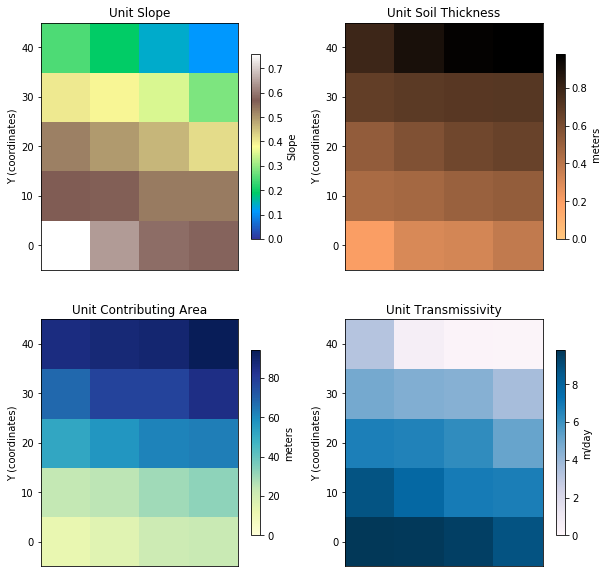

In [8]:
fields=['topographic__slope','soil__thickness','topographic__specific_contributing_area','soil__transmissivity']
maxval=[grid_d1.at_node['topographic__slope'].max(),
        grid_d1.at_node['soil__thickness'].max(),
        grid_d1.at_node['topographic__specific_contributing_area'].max(),
        grid_d1.at_node['soil__transmissivity'].max(),]
subtitles=['Unit Slope','Unit Soil Thickness','Unit Contributing Area','Unit Transmissivity']
colors=['terrain','copper_r','YlGnBu','PuBu']
scalelabel=['Slope',' meters','meters','m/day']

pl.plot_landslide_4variables([221,222,223,224],
                          grid_d1,grid_d1,grid_d1,grid_d1,
                          fields,maxval,
                          subtitles,colors,scalelabel)

In [9]:
#Default relative wetness calculated with unitgrid input values 
#this is used to calculate the max and min Depth and Recharge for plotting
relative_wetness = 0.75


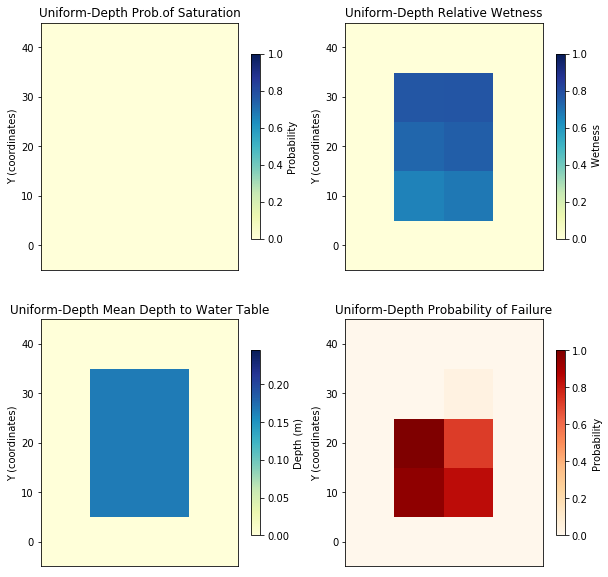

In [10]:
#Main Plot inputs
pgrid = LS_prob1_d.grid
[unit_R,unit_D]=test.scenario_unit_explorer(relative_wetness,pgrid) #set max
#Landslide plot inputs for Uniform Depth forcing
fields=['soil__probability_of_saturation','soil__mean_relative_wetness','soil__mean_watertable_depth','landslide__probability_of_failure']
maxval=[1,1, unit_D[1],1,]
colors=['YlGnBu','YlGnBu','YlGnBu','OrRd']
scalelabel=['Probability',' Wetness','Depth (m)','Probability']
subtitle=['Prob.of Saturation','Relative Wetness','Mean Depth to Water Table','Probability of Failure']
smashtitle=subtitle
ptitle = "Uniform-Depth %s"
for s in subtitle: smashtitle[subtitle.index(s)]="".join(ptitle % (s))
    
pl.plot_landslide_4variables([221,222,223,224],
                          pgrid,pgrid,pgrid,pgrid,
                          fields,maxval,
                          smashtitle,colors,scalelabel)

### Uniform-Recharge
Recharge outputs are in meters (m), here we convert the recharge to mm/day and add to the grid. 

In [11]:
print(unit_R)
recharge_mm_per_m=1000
LS_prob1_r.grid.at_node['soil__mean_recharge_mm']=recharge_mm_per_m * LS_prob1_r.grid.at_node['soil__mean_recharge']

[0.21158308226351061, 429.95313818623936, 88.514077976873821, 110.11583638971329]


In [12]:
pgrid = LS_prob1_r.grid
[unit_R,unit_D]=test.scenario_unit_explorer(rel_wet,pgrid)
fields=['soil__probability_of_saturation','soil__mean_relative_wetness','soil__mean_recharge_mm','landslide__probability_of_failure']
maxval=[1,1, unit_R[1],1,]
colors=['YlGnBu','YlGnBu','YlGnBu','OrRd']
scalelabel=['Probability',' Wetness','Recharge (mm/day)','Probability']
subtitle=['Prob.of Saturation','Relative Wetness','Mean Recharge','Probability of Failure']
smashtitle=subtitle
ptitle = "Uniform-Recharge %s"
for s in subtitle: smashtitle[subtitle.index(s)]="".join(ptitle % (s))
    
pl.plot_landslide_4variables([221,222,223,224],
                          pgrid,pgrid,pgrid,pgrid,
                          fields,maxval,
                          smashtitle,colors,scalelabel)

NameError: name 'rel_wet' is not defined

# 2.0 Unit Test Parameter Initialization 

#### Specify Unit Defaults to Test Hydrologic Forcing Options (2 options) and  Distribution Methods (4 options)
Given unit input values for recharge `unit_R` (mm/day) and depth forcings  `unit_D` (meters), use the unit tests to initialize the parameters using the `LandslideProbability()` function. 

### 2.1 Calculate unit test default values for recharge and depth forcing variables given a unit value for relative wetness (rw=0.75)
These are two different options used for calculating relative wetness which is input to the Factor of Safety Equation.  The unit test has options for comparing the range of input parameters, and  `T` and `area`are inputs to the recharge option calculation of relative wetness.

The plot_landslides functions include `scenario_unit_explorer()` which solves for a unit recharge f(Transmissivity, Slope, Area) and unit depth f(soil thickness) given a uniform value of relative wetness. Using default unit parameters from the unit grid, a single seed for the random distributions, and rw=0.75, we can solve for a set of input hydrologic forcing parameters, and then use the unit hydrology to solve for a known probability of failure in the unit test. 

Recharge = ((rw * (T * theta )) / a)

Depth = hs - rw * hs

In [ ]:
#T = grid['node']['soil__transmissivity']
#theta = np.sin(np.arctan(grid['node']['topographic__slope']))
#hs = grid['node']['soil__thickness'] 
#a_unit = grid['node']['topographic__specific_contributing_area']

#Select a test to compare R and D min/max bounds
relative_wetness = 0.75
[unit_R,unit_D]=test.scenario_unit_explorer(relative_wetness,LS_prob1_r.grid)

In [ ]:
print("When RW = {value}, Unit Test Mean Depth to Water Table = {value2} m".format(value=0.75, value2=round(unit_D[2],2)))
print("When RW = {value}, Unit Test Mean Recharge = {value2} mm/day".format(value=0.75, value2=round(unit_R[2])))


### 2.2 Number of iterations to run Monte Carlo simulation

The landslide component employes the infinite slope model to calculate factor-of-safety values using a Monte Carlo simulation approach, which randomly selects input values from parameter distributions. You can pick the number of iterations to run Monte Carlo simulations, but the unit default is 25 and landscape default is 250. The higher the number of iteration, the longer the program runs, but the more precise the probability of failure result becomes.<br /> 

In [ ]:
n = 25

There are _four_ different options for providing recharge for the Monte Carlo simulation.  We provide each of these grouped with depth to water table and recharge options below by specifying option inputs (a statistical distribution per node and option parameters. <br /> 

### 2.3. Recharge and Depth Options - 'uniform' distribution

See above. 

### 2.4. Recharge and Depth Options - 'lognormal' distribution

In this option, we specify a lognormal distribution with a recharge and depth mean and standard deviation values.  We instantiate the LandslideProbabilty class to create a new object or 'instance' of the class/component LandslideProbability. So now we have created two instances.

In [ ]:
distribution2 = 'lognormal'
uniform_default,grid_r2 = build_landslide_unitgrid(shape,spacing,coordinates,'recharge')
uniform_default,grid_d2 = build_landslide_unitgrid(shape,spacing,coordinates,'depth')

LS_prob2_r = LandslideProbability(grid_r2,number_of_iterations=n,
    groundwater__recharge_distribution=distribution2,
    groundwater__recharge_mean=unit_R[2],
    groundwater__recharge_standard_deviation=unit_R[3])
LS_prob2_r.calculate_landslide_probability()

LS_prob2_d = LandslideProbability(grid_d2,number_of_iterations=n,
    groundwater__depth_distribution=distribution2,
    groundwater__depth_mean=unit_D[2],
    groundwater__depth_standard_deviation=unit_D[3])
LS_prob2_d.calculate_landslide_probability()


### 2.5. Recharge and Depth Options - 'lognormal_spatial' distribution

Similar to the previous option (#2), we use a lognormal distribution for recharge and depth.  However, in this case we provide arrays to represent mean and standard deviation values for each node in our grid.  Thus, the distribution varies for each node - representing a spatially varying distribution of recharge and depth.

In [ ]:
distribution3 = 'lognormal_spatial'
gridnum=grid_r1.number_of_nodes
uniform_default,grid_r3 = build_landslide_unitgrid(shape,spacing,coordinates,'recharge')
uniform_default,grid_d3 = build_landslide_unitgrid(shape,spacing,coordinates,'depth')

Remean3 = np.random.uniform(unit_R[0],unit_R[1],gridnum)
Restandard_deviation3 = np.random.rand(gridnum)
LS_prob3_r = LandslideProbability(grid_r3,number_of_iterations=n,
    groundwater__recharge_distribution=distribution3,
    groundwater__recharge_mean=Remean3,
    groundwater__recharge_standard_deviation=Restandard_deviation3)
LS_prob3_r.calculate_landslide_probability()

Demean3 = np.random.uniform(unit_D[0],unit_D[1],gridnum)
Destandard_deviation3 = np.random.rand(gridnum)
LS_prob3_d = LandslideProbability(grid_d3,number_of_iterations=n,
    groundwater__depth_distribution=distribution3,
    groundwater__depth_mean=Demean3,
    groundwater__depth_standard_deviation=Destandard_deviation3)
LS_prob3_d.calculate_landslide_probability()


### 2.6. Recharge and Depth 'data_driven_spatial' distributions 

### 2.6.1 Generate Recharge input option 

This is the most complex representation of recharge used in the LandslideProbability component.  
In this case, we provide recharge distributions (arrays) directly that are unique for each node.  

In a real-world situation, we would acquire these from a hydrologic model that often has a coarser resolution than our grid.<br />
Thus, we route the recharge data arrays from these larger Hydraulic Source Domain (HSD) grids down to each node of our grid. Landlab has a 'Source tracking algorithm' utility that performs this routing and produces Python dictionaries (_key: value_ pairs) that become parameters for the 'data_driven_spatial' recharge distribution.  In this synthetic example, we'll generate synthetic versions of these dictionaries.

In [ ]:
HSD_dict = {}
for vkey in range(2,8):  #the first example vkey =2 is printed below
    HSD_dict[vkey] = np.random.uniform(unit_R[0],unit_R[1],10)    # 20 - 120 mm/day 
print('HSD_dict dictionary is a unique array of recharge provided as arrays (‘values’) for each of the Hydrologic Source Domain (HSD) (‘keys’). ')    
print('The entire synthetic dictionary is:')
print(HSD_dict)
print('The array for the HSD vkey = 2 of this unordered dictionary is:')
print(HSD_dict[2])

***Note: this is a much lower recharge than the uniform.

HSD_ID dictionary has the grid node ID as ‘keys’ and HSD IDs in a list as ‘values’. 

In [ ]:
HSD_id_dict = {}
for ckey in grid.core_nodes:
    HSD_id_dict[ckey] = np.random.randint(2,8,2)
print('The entire ID synthetic dictionary is:')
print(HSD_id_dict)
print('The array for the ckey = 5, the first index of core nodes in the dictionary is:')
print(HSD_id_dict[5])
print('The two values in the array are the multiple vkeys that correspond/drain to the ckey:')


The fractions dictionary assigns to each node ID as ‘key’ a lists the fractions of each HSD draining to the node as ‘values’. 

In [ ]:
fract_dict = {}
for ckey in grid.core_nodes:
    fract_dict[ckey] =  np.random.rand(2)
print('The entire ID synthetic dictionary is:')
print(fract_dict)
print('The fractional values (sum=1) in the array can be used to add the multiple vkeys that correspond/drain to each key:')
print(fract_dict[5])

In [ ]:
#HSD_inputs_r

When the component is instantiated, the three dictionaries are provided as the 'parameters' for the distribution in explicit order.

### 2.6.2 Generate Depth to water table Input option

In [ ]:
key=np.arange(grid.number_of_nodes)
HSD_inputs_d={}

for i in range(grid.number_of_nodes):
    annualmaxDWT=np.random.uniform(unit_D[0],unit_D[1],10)
    HSD_inputs_d[i] = (annualmaxDWT)

#print(HSD_inputs_d)
print('The values assigned to the first node (key) are: ')
print(HSD_inputs_d[0])

### Data driven spatially distributed landslide component input distributions

In [ ]:
distribution4 = 'data_driven_spatial'
uniform_default,grid_r4 = build_landslide_unitgrid(shape,spacing,coordinates,'recharge')
uniform_default,grid_d4 = build_landslide_unitgrid(shape,spacing,coordinates,'depth')

HSD_inputs_r = [HSD_dict,HSD_id_dict,fract_dict]
LS_prob4_r = LandslideProbability(grid_r4,number_of_iterations=n,
    groundwater__recharge_distribution=distribution4,
    groundwater__recharge_HSD_inputs=HSD_inputs_r)
LS_prob4_r.calculate_landslide_probability()

LS_prob4_d = LandslideProbability(grid_d4,number_of_iterations=n,
    groundwater__depth_distribution=distribution4,
    groundwater__depth_HSD_inputs=HSD_inputs_d)
LS_prob4_d.calculate_landslide_probability()


# 4.0 Plot Synthetic Landslides 

## 4.1 Landslide Component Syntethic Default Outputs
### Uniform-Depth

In [ ]:
pgrid = LS_prob1_d.grid
fields=['soil__probability_of_saturation','soil__mean_relative_wetness','soil__mean_watertable_depth','landslide__probability_of_failure']
maxval=[1,1, unit_D[1],1,]
colors=['YlGnBu','YlGnBu','YlGnBu','OrRd']
scalelabel=['Probability',' Wetness','Depth (m)','Probability']
subtitle=['Prob.of Saturation','Relative Wetness','Mean Depth to Water Table','Probability of Failure']
smashtitle=subtitle

ptitle = "Uniform-Depth %s"
for s in subtitle: smashtitle[subtitle.index(s)]="".join(ptitle % (s))
    
pl.plot_landslide_4variables([221,222,223,224],
                          pgrid,pgrid,pgrid,pgrid,
                          fields,maxval,
                          smashtitle,colors,scalelabel)

### Uniform-Recharge
Recharge outputs are in meters (m), here we convert the recharge to mm/day and add to the grid. 

In [ ]:
recharge_mm_per_m=1000
grid_r1.at_node['soil__mean_recharge_mm']=recharge_mm_per_m * grid_r1.at_node['soil__mean_recharge']

In [ ]:
pgrid = LS_prob1_r.grid
fields=['soil__probability_of_saturation','soil__mean_relative_wetness','soil__mean_recharge_mm','landslide__probability_of_failure']
maxval=[1,1, unit_R[1],1,]
colors=['YlGnBu','YlGnBu','YlGnBu','OrRd']
scalelabel=['Probability',' Wetness','Recharge (mm/day)','Probability']
subtitle=['Prob.of Saturation','Relative Wetness','Mean Recharge','Probability of Failure']
smashtitle=subtitle

ptitle = "Uniform-Recharge %s"
for s in subtitle: smashtitle[subtitle.index(s)]="".join(ptitle % (s))
    
pl.plot_landslide_4variables([221,222,223,224],
                          pgrid,pgrid,pgrid,pgrid,
                          fields,maxval,
                          smashtitle,colors,scalelabel)


### Data Driven Spatial- Depth

In [ ]:
pgrid = LS_prob4_d.grid
fields=['soil__probability_of_saturation','soil__mean_relative_wetness','soil__mean_watertable_depth','landslide__probability_of_failure']
maxval=[1,1, unit_D[1],1,]
colors=['YlGnBu','YlGnBu','YlGnBu','OrRd']
scalelabel=['Probability',' Wetness','Depth (m)','Probability']
subtitle=['Prob.of Saturation','Relative Wetness','Mean Depth to Water Table','Probability of Failure']
smashtitle=subtitle
ptitle = "Data-Spatial-Depth %s"
for s in subtitle: smashtitle[subtitle.index(s)]="".join(ptitle % (s))
    
pl.plot_landslide_4variables([221,222,223,224],
                          pgrid,pgrid,pgrid,pgrid,
                          fields,maxval,
                          smashtitle,colors,scalelabel)


### Data Driven Spatial- Recharge
Recharge outputs are in meters (m), here we convert the recharge to mm/day and add to the grid. 

In [ ]:
recharge_mm_per_m=1000
LS_prob4_r.grid.at_node['soil__mean_recharge_mm']=recharge_mm_per_m * LS_prob4_r.grid.at_node['soil__mean_recharge']

In [ ]:
pgrid = LS_prob4_r.grid
fields=['soil__probability_of_saturation','soil__mean_relative_wetness','soil__mean_recharge_mm','landslide__probability_of_failure']
maxval=[1,1, unit_R[1],1,]
colors=['YlGnBu','YlGnBu','YlGnBu','OrRd']
scalelabel=['Probability',' Wetness','Recharge (mm/day)','Probability']
subtitle=['Prob.of Saturation','Relative Wetness','Mean Recharge','Probability of Failure']
smashtitle=subtitle

ptitle = "Data-Spatial-Recharge %s"
for s in subtitle: smashtitle[subtitle.index(s)]="".join(ptitle % (s))
    
pl.plot_landslide_4variables([221,222,223,224],
                          pgrid,pgrid,pgrid,pgrid,
                          fields,maxval,
                          smashtitle,colors,scalelabel)


## 4.3 Landslide Component Unit Test Outputs: Probability of Failure 
### Unit default landslide parameters; hydrologic forcings with four statistical distribution methods

### Depth to groundwater

In [ ]:
fields=['landslide__probability_of_failure','landslide__probability_of_failure','landslide__probability_of_failure','landslide__probability_of_failure']
maxval=[1,1,1,1]
subtitles=['Uniform-Depth-Failure','Lognormal-Depth-Failure','LN-Spatial-Depth-Failure','DataSpatial-Depth-Failure']
colors=['OrRd','OrRd','OrRd','OrRd']
scalelabel=['Probability','Probability','Probability','Probability']

pl.plot_landslide_4variables([221,222,223,224],
                          LS_prob1_d.grid,LS_prob2_d.grid,LS_prob3_d.grid,LS_prob4_d.grid,
                          fields,maxval,
                          subtitles,colors,scalelabel)

### Unit default landslide parameters; hydrologic forcings with four statistical distribution methods

### Recharge

In [ ]:
fields=['landslide__probability_of_failure','landslide__probability_of_failure','landslide__probability_of_failure','landslide__probability_of_failure']
maxval=[1,1,1,1,]
subtitles=['Uniform-Recharge-Failure','Lognormal-Recharge-Failure','LN-Spatial-Recharge-Failure','DataSpatial-Recharge-Failure']
colors=['OrRd','OrRd','OrRd','OrRd']
scalelabel=['Probability','Probability','Probability','Probability']

pl.plot_landslide_4variables([221,222,223,224],
                          LS_prob1_r.grid,LS_prob2_r.grid,LS_prob3_r.grid,LS_prob4_r.grid,
                          fields,maxval,
                          subtitles,colors,scalelabel)

## 4.4 Run Landslide Component 
This is helpful to demonstrate and verify the difference between running a model unit test (results are static) and running the model with random variables introduced in each model instance of executing `calculate_landslide_probability()`

**Use Landslide Component** to calculate data driven spatial failure probability with two methods (depth, recharge) **different results are expected each time this is run**

In [ ]:
print("Recharge Hydrologic Forcing")
print("Uniform-Depth Hydrologic Forcing")
test.print_list_nodevalues(LS_prob1_r,["landslide__probability_of_failure"])
print("Lognormal-Depth Hydrologic Forcing")
test.print_list_nodevalues(LS_prob2_r,["landslide__probability_of_failure"])
print("Lognormal-Spatial-Depth Hydrologic Forcing")
test.print_list_nodevalues(LS_prob3_r,["landslide__probability_of_failure"])
print("Data-Spatial-Depth Hydrologic Forcing")
test.print_list_nodevalues(LS_prob4_r,["landslide__probability_of_failure"])


In [ ]:
print("Uniform-Depth Hydrologic Forcing")
test.print_failure_nodevalues(LS_prob1_d)
print("Lognormal-Depth Hydrologic Forcing")
test.print_failure_nodevalues(LS_prob2_d)
print("Lognormal-Spatial-Depth Hydrologic Forcing")
test.print_failure_nodevalues(LS_prob3_d)
print("Data-Spatial-Depth Hydrologic Forcing")
test.print_failure_nodevalues(LS_prob4_d)

## Citing Landlab Landslide Component

**If you use any portion of Landlab, you must cite the following papers:**

Hobley, D. E. J., Adams, J. M., Nudurupati, S. S., Hutton, E. W. H., Gasparini, N. M., Istanbulluoglu, E. and Tucker, G. E., 2017, Creative computing with Landlab: an open-source toolkit for building, coupling, and exploring two-dimensional numerical models of Earth-surface dynamics, Earth Surface Dynamics, 5, p 21-46, 10.5194/esurf-5-21-2017.

Barnhart, K. R., Hutton, E. W. H., Tucker, G. E., Gasparini, N. M., Istanbulluoglu, E., Hobley, D. E. J., Lyons, N. J., Mouchene, M., Nudurupati, S. S., Adams, J. M., and Bandaragoda, C.: Short communication: Landlab v2.0: A software package for Earth surface dynamics, Earth Surf. Dynam. Discuss., https://doi.org/10.5194/esurf-2020-12, in review, 2020.
                
**If you use any portion of the Landlab Landslide Component, you must cite the following paper:**
Strauch, R., Istanbulluoglu, E., Nudurupati, S.S., Bandaragoda, C., Gasparini, N.M. and Tucker, G.E., 2018. A hydroclimatological approach to predicting regional landslide probability using Landlab. Earth Surface Dynamics, 6(1), pp.49-49.

<img src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png" style="float:right;width:150px;padding:20px">   


The development of this Notebook has been made possible by the Landlab project funded by the National Science Foundation (OAC 1450338 to N. Gasparini, OAC 1450409 to G. Tucker, OAC 1450412 to E. Istanbulluoglu).

We acknowledge that this research takes place in the ancestral homelands of Tribes, Bands, and First Nations, including most notably the Upper Skagit Indian Tribe, Sauk-Suiattle Indian Tribe, Swinomish Indian Tribal Community, Samish Indian Nation, Nooksack Tribe, Lummi Nation, Stó:lō Nation, Nlaka’pamux Nation, Colville Confederated Tribes, Syilx/Okanagan Nation.  The University of Washington acknowledges the Coast Salish peoples of this land, the land which touches the shared waters of all tribes and bands within the Suquamish, Tulalip and Muckleshoot nations. 


<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>
<hr>